# StrainGST comparisons

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn

from strainge.io.utils import parse_straingst

seaborn.set()

In [3]:
BASE_PATH = Path("benchmarks/straingst/")
SAMPLE_DIR = BASE_PATH / "samples"
STRAINGST_DIR = BASE_PATH / "straingst"
STRAINEST_DIR = BASE_PATH / "strainest"
BIB_DIR = BASE_PATH / "bib"

## Collect truth 

### Collect pairwise mash distances

In [4]:
with (BASE_PATH / "strainest_db/dist_matrix.phylip").open() as f:
    fiter = iter(f)
    num_entries = int(next(fiter))
    reference_names = []
    
    matrix = numpy.zeros((num_entries, num_entries))
    for i, line in enumerate(fiter):
        parts = line.strip().split('\t')
        reference_names.append(parts[0])
        row = numpy.array([float(v) for v in parts[1:]])
        if len(row) > 0:
            matrix[i, 0:len(row)] = row
        
    index_upper = numpy.triu_indices(num_entries)
    matrix[index_upper] = matrix.T[index_upper]
    
dmatrix = pandas.DataFrame(matrix, index=reference_names, 
                           columns=reference_names)
dmatrix


,Esch_albertii_05-3106.sketch,Esch_albertii_06-3542.sketch,Esch_albertii_07-3866.sketch,Esch_albertii_1551-2.sketch,Esch_albertii_2012EL-1823B.sketch,Esch_albertii_2013C-4143.sketch,Esch_albertii_2014C-4015.sketch,Esch_albertii_2014C-4356.sketch,Esch_albertii_CB9786.sketch,Esch_albertii_ChinaSP140150.sketch,...,Shig_flexneri_NCTC_9728.sketch,Shig_flexneri_SFL1520.sketch,Shig_flexneri_Shi06HN006.sketch,Shig_flexneri_Y394.sketch,Shig_sonnei_866.sketch,Shig_sonnei_AR_0030.sketch,Shig_sonnei_AUSMDU00008333.sketch,Shig_sonnei_FDAARGOS_524.sketch,Shig_sonnei_FDAARGOS_90.sketch,Shig_sp._PAMC_28760.sketch
Esch_albertii_05-3106.sketch,0.000000,0.016799,0.014547,0.012122,0.018181,0.012060,0.017687,0.014467,0.016129,0.013664,...,0.081351,0.081835,0.080872,0.080872,0.079934,0.079200,0.081063,0.080968,0.079658,0.079750
Esch_albertii_06-3542.sketch,0.016799,0.000000,0.015532,0.016412,0.007240,0.016821,0.007323,0.016107,0.006755,0.016140,...,0.079474,0.079658,0.079200,0.078929,0.079110,0.078127,0.079750,0.079019,0.078038,0.078038
Esch_albertii_07-3866.sketch,0.014547,0.015532,0.000000,0.013954,0.017398,0.013857,0.016810,0.010431,0.015967,0.012292,...,0.081254,0.082129,0.082823,0.082326,0.081447,0.081063,0.081640,0.081738,0.080778,0.080683
Esch_albertii_1551-2.sketch,0.012122,0.016412,0.013954,0.000000,0.018228,0.011194,0.017827,0.013905,0.015935,0.013190,...,0.082923,0.083024,0.082326,0.082227,0.081640,0.081447,0.082524,0.081933,0.081640,0.081063
Esch_albertii_2012EL-1823B.sketch,0.018181,0.007240,0.017398,0.018228,0.000000,0.018240,0.007753,0.017617,0.008811,0.017629,...,0.080213,0.081159,0.080589,0.079566,0.079842,0.079566,0.080307,0.080027,0.078839,0.078215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shig_sonnei_AR_0030.sketch,0.079200,0.078127,0.081063,0.081447,0.079566,0.079474,0.078038,0.078570,0.078127,0.081640,...,0.018312,0.018492,0.017803,0.017640,0.002535,0.000000,0.003967,0.003037,0.002244,0.016810
Shig_sonnei_AUSMDU00008333.sketch,0.081063,0.079750,0.081640,0.082524,0.080307,0.080778,0.077169,0.079292,0.079200,0.081351,...,0.018820,0.019103,0.018432,0.018360,0.001865,0.003967,0.000000,0.002029,0.002437,0.017594
Shig_sonnei_FDAARGOS_524.sketch,0.080968,0.079019,0.081738,0.081933,0.080027,0.080027,0.076827,0.081063,0.078392,0.082524,...,0.017991,0.018205,0.017444,0.017204,0.001486,0.003037,0.002029,0.000000,0.001209,0.016544
Shig_sonnei_FDAARGOS_90.sketch,0.079658,0.078038,0.080778,0.081640,0.078839,0.079658,0.077775,0.077863,0.077514,0.080872,...,0.017944,0.018110,0.017398,0.017159,0.001342,0.002244,0.002437,0.001209,0.000000,0.016555


### Collect StrainGST database clustering results

In [5]:
STRAINGST_DB = Path("/gsap/archive-bacterial/Projects/StrainGE/straingst-benchmarks/db")
CLUSTERS = STRAINGST_DB / "clusters90.tsv"

ref_cluster = {}
in_db = set()
with CLUSTERS.open() as f:
    for line in f:
        parts = line.split('\t')
        it = iter(parts)
        cluster_rep = next(it).strip()
        
        ref_cluster[cluster_rep] = cluster_rep
        in_db.add(cluster_rep)
        
        for ref in it:
            ref_cluster[ref] = cluster_rep

### Check strains that were discarded because they were for >99% contained in another genome

In [6]:
dmatrix_only_in_db = dmatrix[[c for c in dmatrix.columns if c.replace(".sketch", "") in in_db]].copy()

for ref in dmatrix_only_in_db.index:
    ref = ref.replace(".sketch", "")
    
    new_ref = dmatrix_only_in_db.loc[ref + ".sketch"].idxmin().replace(".sketch", "")
    
    if ref not in ref_cluster:
        ref_cluster[ref] = new_ref

In [7]:
def get_sample_type(sample_id):
    sample_type = sample_id.split('/')[0]
    
    if sample_type[-1].isdigit():
        sample_type = sample_type[:-1]
        
    if sample_type == "single":
        return "equal"
        
    return sample_type


def get_num_strains(sample_id):
    if sample_id.startswith('single'):
        return 1
    else:
        sample_type = sample_id.split('/')[0]
        return int(sample_type[-1])

### True strains in each sample

In [8]:
sample_data = []
for fpath in SAMPLE_DIR.glob("**/refs.txt"):
    refs = []
    with fpath.open() as f:
        for line in f:
            name, orig_path = line.split('\t')
            refs.append(name)
            
    sample_id = str(fpath.relative_to(SAMPLE_DIR).parent)
        
    for i, ref in enumerate(refs):
        sample_data.append({
            'sample_id': sample_id,
            'i': i,
            'true_ref': ref
        })
        

truth_df = pandas.DataFrame(sample_data).set_index(['sample_id', 'i']).sort_index()
truth_df['in_db'] = truth_df['true_ref'].isin(in_db)
truth_df['cluster_rep'] = truth_df['true_ref'].map(ref_cluster)
with pandas.option_context('display.max_rows', None):
    display(truth_df)

true_ref  in_db  \
sample_id         i                                                 
equal2/sample1    0                     Esch_coli_ECP17-46  False   
                  1                         Esch_coli_TR01   True   
equal2/sample10   0                       Esch_coli_HS13-1  False   
                  1                          Esch_coli_144  False   
equal2/sample11   0                         Esch_coli_ML35   True   
                  1                     Esch_coli_ExPEC_XM  False   
equal2/sample12   0                     Esch_coli_EC-TO143  False   
                  1                         Esch_coli_E706   True   
equal2/sample13   0                   Esch_coli_2011C-3911   True   
                  1                     Shig_boydii_83-578   True   
equal2/sample14   0                         Esch_coli_WB61   True   
                  1                 Esch_marmotae_HT073016   True   
equal2/sample15   0                          Esch_coli_139  False   
                  1                        Esch_coli_F6699   True   
equal2/sample2    0                      Esch_coli_BW25113  False   
                  1                   Esch_coli_2013C-3492  False   
equal2/sample3    0                         Esch_coli_6409   True   
                  1                      Esch_coli_97-3250  False   
equal2/sample4    0             Esch_fergusonii_ATCC_35469   True   
                  1                       Esch_coli_RM9131  False   
equal2/sample5    0                        Esch_coli_81009  False   
                  1                      Esch_coli_AR_0058  False   
equal2/sample6    0                          Esch_coli_124  False   
                  1                          Esch_coli_141  False   
equal2/sample7    0                          Esch_coli_147  False   
                  1                          Esch_coli_350  False   
equal2/sample8    0                         Esch_coli_PA20  False   
                  1                   Esch_coli_ATCC_25922  False   
equal2/sample9    0                         Esch_coli_SE15  False   
                  1                       Esch_coli_KR2009  False   
equal3/sample1    0                    Esch_coli_FWSEC0006  False   
                  1                      Esch_coli_08-3918  False   
                  2        Esch_coli_ST540_GCF_000599645.1  False   
equal3/sample10   0            Shig_dysenteriae_2017C-4522  False   
                  1                    Esch_coli_NCCP15648   True   
                  2                   Esch_coli_SCEC020023   True   
equal3/sample11   0                        Esch_coli_10671  False   
                  1                          Esch_coli_2FA  False   
                  2                   Esch_coli_2015C-3125  False   
equal3/sample12   0                           Esch_coli_4A  False   
                  1                         Esch_coli_CRE1  False   
                  2                   Esch_coli_2013C-4465  False   
equal3/sample13   0                           Esch_coli_C4   True   
                  1                      Esch_coli_HKUOPY1   True   
                  2                        Esch_coli_214-4   True   
equal3/sample14   0                      Esch_coli_AR_0061   True   
                  1                 Shig_boydii_ATCC_49812   True   
                  2                       Esch_coli_REL606  False   
equal3/sample15   0                       Esch_coli_YSP8-1   True   
                  1                           Esch_coli_C4   True   
                  2                          Esch_coli_130  False   
equal3/sample2    0                       Esch_coli_SK1144  False   
                  1                           Esch_coli_D6   True   
                  2                    Esch_coli_NCTC10537  False   
equal3/sample3    0           Esch_coli_K-12_substr_MC4100  False   
                  1                           Esch_coli_7A  False   
                  2                       Esch_c

In [9]:
ref_df = truth_df.copy().reset_index().set_index(['sample_id', 'true_ref'])

## Collect StrainGST results

In [10]:
straingst_data = []
for fname in STRAINGST_DIR.glob("**/sample.tsv"):
    sample_id = str(fname.relative_to(STRAINGST_DIR).parent.parent)
    cov = fname.parent.parts[-1]
    if cov == 'mock_community':
        continue
        
    with fname.open() as f:
        for r in parse_straingst(f):
            straingst_data.append({
                'sample_id': sample_id,
                'coverage': cov,
                **r
            })
        
straingst_df = pandas.DataFrame(straingst_data)
straingst_df['i'] = pandas.to_numeric(straingst_df['i'])
straingst_df = straingst_df.set_index(['coverage', 'sample_id']).sort_index()

straingst_df

i                    strain gkmers ikmers  \
coverage     sample_id                                                     
0.1x         equal2/sample1    0             Esch_coli_149  51737  51727   
             equal2/sample1    1            Esch_coli_TR01  52056   9133   
             equal2/sample10   0             Esch_coli_149  51737  51727   
             equal2/sample10   1      Esch_coli_ATCC_11775  48323  24290   
             equal2/sample11   0            Esch_coli_ML35  47425  47413   
...                           ..                       ...    ...    ...   
1x_0.5x_0.1x unequal3/sample8  1          Esch_coli_RM9872  51057  21997   
             unequal3/sample8  2             Esch_coli_149  51737  11769   
             unequal3/sample9  0  Shig_flexneri_ATCC_29903  42595  42550   
             unequal3/sample9  1             Esch_coli_H10  47234  17803   
             unequal3/sample9  2           Esch_coli_PA45B  50048  23163   

                              skmers    cov   kcov   gcov   acct   even  \
coverage     sample_id                                                    
0.1x         equal2/sample1     7818  0.134  1.105  0.142  0.872  0.986   
             equal2/sample1      876  0.070  1.064  0.073  0.609  0.999   
             equal2/sample10    7639  0.105  1.091  0.110  0.702  0.989   
             equal2/sample10    2210  0.074  1.045  0.076  0.746  0.996   
             equal2/sample11    7321  0.110  1.086  0.115  0.701  0.992   
...                              ...    ...    ...    ...    ...    ...   
1x_0.5x_0.1x unequal3/sample8   9604  0.348  1.298  0.412  0.805  0.971   
             unequal3/sample8   1949  0.084  1.089  0.087  0.447  0.994   
             unequal3/sample9  35573  0.640  1.687  1.028  0.818  0.996   
             unequal3/sample9   8361  0.305  1.235  0.370  0.655  0.986   
             unequal3/sample9   2937  0.079  1.065  0.083  0.549  0.986   

                                spec  rapct wscore  score  
coverage     sample_id                                     
0.1x         equal2/sample1    1.080  0.033  0.105  0.114  
             equal2/sample1    1.034  0.017  0.041  0.043  
             equal2/sample10   1.065  0.025  0.068  0.072  
             equal2/sample10   1.007  0.016  0.054  0.055  
             equal2/sample11   1.024  0.024  0.074  0.076  
...                              ...    ...    ...    ...  
1x_0.5x_0.1x unequal3/sample8  1.082  0.095  0.244  0.264  
             unequal3/sample8  1.120  0.020  0.033  0.037  
             unequal3/sample9  0.890  0.204  0.462  0.519  
             unequal3/sample9  1.117  0.076  0.174  0.194  
             unequal3/sample9  1.020  0.018  0.041  0.042  

[732 rows x 14 columns]

In [11]:
straingst_eval = []

for ix in straingst_df.index.unique():
    cov, sample_id = ix 
    
    true_strains = set(truth_df.loc[sample_id, 'cluster_rep'])
    reported = set(straingst_df.loc[ix, 'strain'])
    
    tp = reported & true_strains
    fp = reported - true_strains
    fn = true_strains - reported
    
    in_db_strains = {ref_df.loc[(sample_id, s), 'cluster_rep'] for s in truth_df.loc[sample_id, 'true_ref'] if ref_df.loc[(sample_id, s), 'in_db']}
    out_db_strains = {ref_df.loc[(sample_id, s), 'cluster_rep'] for s in truth_df.loc[sample_id, 'true_ref'] if not ref_df.loc[(sample_id, s), 'in_db']}
    num_in_db = len(in_db_strains)
    num_out_db = len(out_db_strains)
    in_db_accuracy = (len(tp & in_db_strains) / num_in_db) if num_in_db > 0 else numpy.nan
    out_db_accuracy = (len(tp & out_db_strains) / num_out_db) if num_out_db > 0 else numpy.nan
    
    #print(cov, sample_id, true_strains, "TP:", tp, "FP:", fp, "FN:", fn)
    
    mash_distances = []
    true_refs = [r + ".sketch" for r in truth_df.loc[sample_id, 'true_ref']]
    for ref in reported:
        mash_distances.append(dmatrix.loc[ref + ".sketch", true_refs].min())
    
    mash_distances.sort()
    mash_distances = mash_distances[:len(truth_df.loc[sample_id])]
    
    straingst_eval.append({
        'cov': cov,
        'sample_id': sample_id,
        'tp': len(tp),
        'fp': len(fp),
        'fn': len(fn),
        'avg_mash_dist': sum(mash_distances) / len(mash_distances),
        'num_in_db': num_in_db,
        'in_db_accuracy': in_db_accuracy,
        'out_db_accuracy': out_db_accuracy
    })
    
straingst_eval = pandas.DataFrame(straingst_eval).set_index(['sample_id', 'cov']).sort_index()
straingst_eval['precision'] = (straingst_eval['tp']) / (straingst_eval['tp'] + straingst_eval['fp'])
straingst_eval['recall'] = (straingst_eval['tp']) / (straingst_eval['tp'] + straingst_eval['fn'])
straingst_eval['f1'] = 2 * ((straingst_eval['precision']*straingst_eval['recall']) / (straingst_eval['precision'] + straingst_eval['recall']))

tp  fp  fn  avg_mash_dist  num_in_db  \
sample_id        cov                                                  
equal2/sample1   0.1x           2   0   0       0.000234          1   
                 0.5x           2   0   0       0.000234          1   
                 10x            2   0   0       0.000234          1   
                 1x             2   0   0       0.000234          1   
equal2/sample10  0.1x           2   0   0       0.002483          0   
...                            ..  ..  ..            ...        ...   
unequal3/sample7 1x_0.5x_0.1x   3   0   0       0.000638          2   
unequal3/sample8 10x_1x_0.5x    3   0   0       0.001083          1   
                 1x_0.5x_0.1x   3   0   0       0.001083          1   
unequal3/sample9 10x_1x_0.5x    3   0   0       0.001342          1   
                 1x_0.5x_0.1x   3   0   0       0.001342          1   

                               in_db_accuracy  out_db_accuracy  precision  \
sample_id        cov                                                        
equal2/sample1   0.1x                     1.0              1.0        1.0   
                 0.5x                     1.0              1.0        1.0   
                 10x                      1.0              1.0        1.0   
                 1x                       1.0              1.0        1.0   
equal2/sample10  0.1x                     NaN              1.0        1.0   
...                                       ...              ...        ...   
unequal3/sample7 1x_0.5x_0.1x             1.0              1.0        1.0   
unequal3/sample8 10x_1x_0.5x              1.0              1.0        1.0   
                 1x_0.5x_0.1x             1.0              1.0        1.0   
unequal3/sample9 10x_1x_0.5x              1.0              1.0        1.0   
                 1x_0.5x_0.1x             1.0              1.0        1.0   

                               recall   f1 sample_type  num_strains  
sample_id        cov                                                 
equal2/sample1   0.1x             1.0  1.0       equal            2  
                 0.5x             1.0  1.0       equal            2  
                 10x              1.0  1.0       equal            2  
                 1x               1.0  1.0       equal            2  
equal2/sample10  0.1x             1.0  1.0       equal            2  
...                               ...  ...         ...          ...  
unequal3/sample7 1x_0.5x_0.1x     1.0  1.0     unequal            3  
unequal3/sample8 10x_1x_0.5x      1.0  1.0     unequal            3  
                 1x_0.5x_0.1x     1.0  1.0     unequal            3  
unequal3/sample9 10x_1x_0.5x      1.0  1.0     unequal            3  
                 1x_0.5x_0.1x     1.0  1.0     unequal            3  

[300 rows x 12 columns]

SpearmanrResult(correlation=0.06673386401962682, pvalue=0.24918794239438205)
SpearmanrResult(correlation=0.03812095038020457, pvalue=0.5567352674171966)
SpearmanrResult(correlation=0.22423936194746918, pvalue=0.08499315152070093)
1.0 0.0
0.9931891025641024 0.05036453830925918
Ttest_indResult(statistic=1.9503436951026538, pvalue=0.05248525417679529)


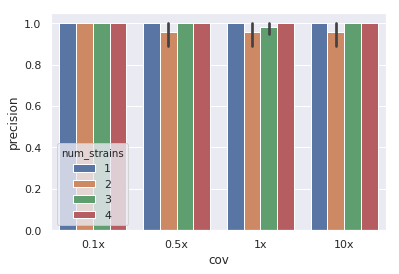

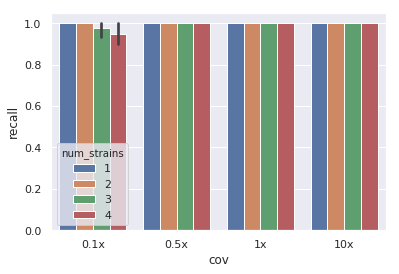

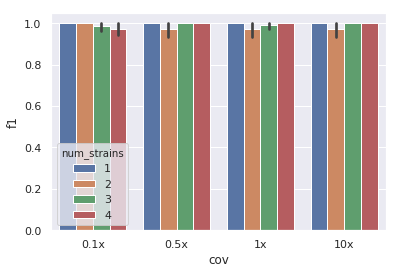

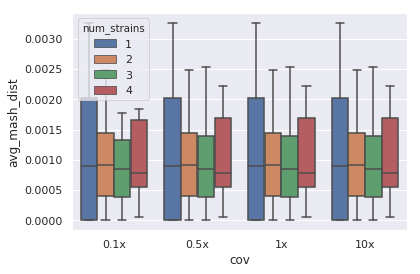

<Figure size 432x288 with 0 Axes>

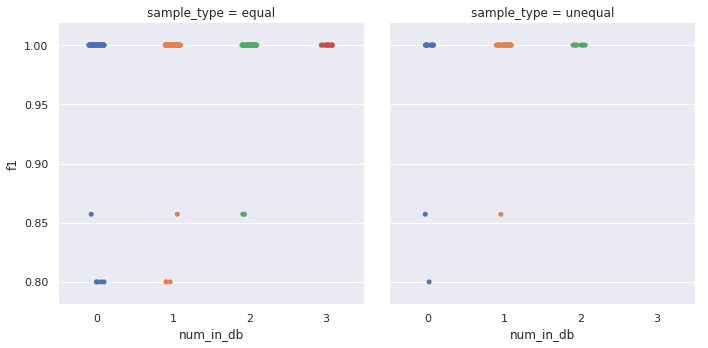

In [12]:
from scipy.stats import ttest_ind, spearmanr

straingst_eval['sample_type'] = straingst_eval.index.map(lambda e: get_sample_type(e[0]))
straingst_eval['num_strains'] = straingst_eval.index.map(lambda e: get_num_strains(e[0]))

straingst_equal = straingst_eval[straingst_eval['sample_type'] == "equal"]
straingst_unequal = straingst_eval[straingst_eval['sample_type'] == "unequal"]

display(straingst_eval)

plt.figure()
seaborn.barplot(data=straingst_equal.reset_index(), x="cov", y="precision", 
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])
plt.figure()
seaborn.barplot(data=straingst_equal.reset_index(), x="cov", y="recall",
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])
plt.figure()
seaborn.barplot(data=straingst_equal.reset_index(), x="cov", y="f1", 
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])

plt.figure()
seaborn.boxplot(data=straingst_equal.reset_index(), x="cov", y="avg_mash_dist",
               hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])

plt.figure()
seaborn.catplot(data=straingst_eval.reset_index(), kind="strip", x="num_in_db", y="f1", col="sample_type")
corr = spearmanr(straingst_eval['num_in_db'], straingst_eval['f1'])
corr_equal = spearmanr(straingst_equal['num_in_db'], straingst_equal['f1'])
corr_unequal = spearmanr(straingst_unequal['num_in_db'], straingst_unequal['f1'])

print(corr)
print(corr_equal)
print(corr_unequal)

print(straingst_equal['in_db_accuracy'].mean(), straingst_equal['in_db_accuracy'].std())
print(straingst_equal['out_db_accuracy'].mean(), straingst_equal['out_db_accuracy'].std())
print(ttest_ind(straingst_equal['in_db_accuracy'], straingst_equal['out_db_accuracy'], equal_var=False, nan_policy='omit'))

## StrainEst results


In [13]:
strainest_eval = []

for fpath in STRAINEST_DIR.glob("**/abund.txt"):
    abun_df = pandas.read_csv(fpath, sep='\t', index_col=0)
    
    sample_id = str(fpath.relative_to(STRAINEST_DIR).parent.parent)
    cov = fpath.parts[-2]
    
    if cov == 'mock_community':
        continue
    
    true_strains = set(truth_df.loc[sample_id, 'cluster_rep'])
    reported = set(s.replace(".fa", "") for s in abun_df[abun_df['alignments.bam'] > 0.01].index)
    
    tp = reported & true_strains
    fp = reported - true_strains
    fn = true_strains - reported
    
    #print(cov, sample_id, true_strains, "TP:", tp, "FP:", fp, "FN:", fn)
    
    mash_distances = []
    true_refs = [r + ".sketch" for r in truth_df.loc[sample_id, 'true_ref']]
    for ref in reported:
        mash_distances.append(dmatrix.loc[ref + ".sketch", true_refs].min())
        
    mash_distances.sort()
    mash_distances = mash_distances[:len(truth_df.loc[sample_id])]
    
    strainest_eval.append({
        'cov': cov,
        'sample_id': sample_id,
        'tp': len(tp),
        'fp': len(fp),
        'fn': len(fn),
        'avg_mash_dist': sum(mash_distances) / len(mash_distances) if mash_distances else numpy.nan
    })
    
strainest_eval = pandas.DataFrame(strainest_eval).set_index(['sample_id', 'cov']).sort_index()
strainest_eval['precision'] = (strainest_eval['tp']) / (strainest_eval['tp'] + strainest_eval['fp'])
strainest_eval['recall'] = (strainest_eval['tp']) / (strainest_eval['tp'] + strainest_eval['fn'])
strainest_eval['f1'] = 2 * ((strainest_eval['precision']*strainest_eval['recall']) / (strainest_eval['precision'] + strainest_eval['recall']))

#strainest_eval['avg_mash_dist'] = strainest_eval['avg_mash_dist'].fillna(1.0)
    

tp  fp  fn  avg_mash_dist  precision    recall  \
sample_id        cov                                                            
equal2/sample1   0.1x           2   1   0       0.000234   0.666667  1.000000   
                 0.5x           2   1   0       0.000234   0.666667  1.000000   
                 10x            2   1   0       0.000234   0.666667  1.000000   
                 1x             2   1   0       0.000234   0.666667  1.000000   
equal2/sample10  0.1x           0   0   2            NaN        NaN  0.000000   
...                            ..  ..  ..            ...        ...       ...   
unequal3/sample7 1x_0.5x_0.1x   1   3   2       0.005870   0.250000  0.333333   
unequal3/sample8 10x_1x_0.5x    3   2   0       0.001083   0.600000  1.000000   
                 1x_0.5x_0.1x   2   1   1       0.002015   0.666667  0.666667   
unequal3/sample9 10x_1x_0.5x    2   1   1       0.002529   0.666667  0.666667   
                 1x_0.5x_0.1x   2   4   1       0.002529   0.333333  0.666667   

                                     f1 sample_type  num_strains  
sample_id        cov                                              
equal2/sample1   0.1x          0.800000       equal            2  
                 0.5x          0.800000       equal            2  
                 10x           0.800000       equal            2  
                 1x            0.800000       equal            2  
equal2/sample10  0.1x               NaN       equal            2  
...                                 ...         ...          ...  
unequal3/sample7 1x_0.5x_0.1x  0.285714     unequal            3  
unequal3/sample8 10x_1x_0.5x   0.750000     unequal            3  
                 1x_0.5x_0.1x  0.666667     unequal            3  
unequal3/sample9 10x_1x_0.5x   0.666667     unequal            3  
                 1x_0.5x_0.1x  0.444444     unequal            3  

[300 rows x 9 columns]

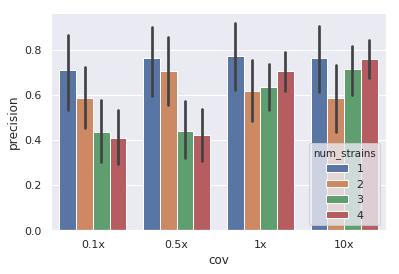

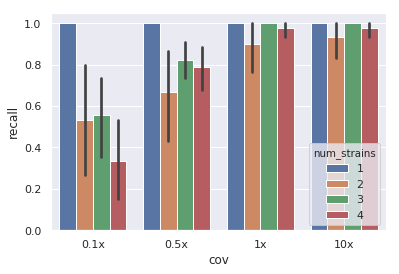

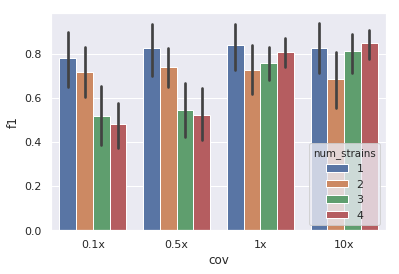

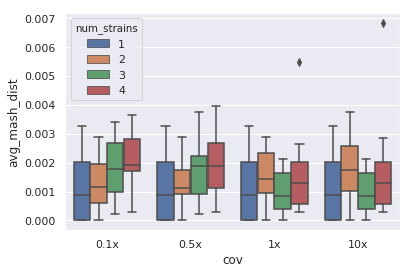

In [14]:
strainest_eval['sample_type'] = strainest_eval.index.map(lambda e: get_sample_type(e[0]))
strainest_eval['num_strains'] = strainest_eval.index.map(lambda e: get_num_strains(e[0]))

display(strainest_eval)

plt.figure()
seaborn.barplot(data=strainest_eval[strainest_eval['sample_type'] == "equal"].reset_index(), x="cov", y="precision", 
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])
plt.figure()
seaborn.barplot(data=strainest_eval[strainest_eval['sample_type'] == "equal"].reset_index(), x="cov", y="recall",
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])
plt.figure()
seaborn.barplot(data=strainest_eval[strainest_eval['sample_type'] == "equal"].reset_index(), x="cov", y="f1", 
                hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])

plt.figure()
seaborn.boxplot(data=strainest_eval[strainest_eval['sample_type'] == "equal"].reset_index(), x="cov", y="avg_mash_dist",
               hue="num_strains", order=["0.1x", "0.5x", "1x", "10x"])

## Collect BIB results

In [15]:
import re

bib_db = []
file_re = re.compile(r'^#Sequence(\d+)File\s+rep_genomes/(.*?)\.fa$')

with (BIB_DIR / "core_alignment.xmfa").open() as f:
    for line in f:
        if not line:
            continue
            
        if not line.startswith('#'):
            break
            
        match = file_re.match(line.strip())
        if match:
            bib_db.append(match.group(2))
            
bib_db

['Esch_albertii_EC06-170',
 'Esch_coli_06-00048',
 'Esch_coli_108',
 'Esch_coli_2013C-4282',
 'Esch_coli_AR_0006',
 'Esch_coli_EC-12536',
 'Esch_coli_H105',
 'Esch_coli_IMT16316',
 'Esch_coli_K-12_substr_GM4792',
 'Esch_coli_LHM10-1',
 'Esch_coli_MSHS_133',
 'Esch_coli_NCTC11104',
 'Esch_coli_NCTC11133',
 'Esch_coli_S40',
 'Esch_coli_ST2747_GCF_000599685.1',
 'Esch_fergusonii_ATCC_35469',
 'Esch_sp._E4742',
 'Shig_dysenteriae_80-547',
 'Shig_dysenteriae_ATCC_12039',
 'Shig_flexneri_G1663']

In [16]:
dmatrix_bib = dmatrix[[c for c in dmatrix.columns if c.replace(".sketch", "") in bib_db]].copy()

bib_rep = {}
for ref in dmatrix.index:
    ref = ref.replace(".sketch", "")
    
    new_ref = dmatrix_bib.loc[ref + ".sketch"].idxmin().replace(".sketch", "")
    bib_rep[ref] = new_ref
    
truth_df['bib_rep'] = truth_df['true_ref'].map(bib_rep)

In [17]:
bib_eval = []

for fpath in BIB_DIR.glob("**/abundance.txt.m_alphas"):
    sample_id = str(fpath.relative_to(BIB_DIR).parent.parent)
    cov = fpath.parts[-2]
    
    if cov == 'mock_community':
        continue
    
    bib_df = pandas.read_csv(fpath, delim_whitespace=True, comment='#', names=['m_theta', 'alpha', 'beta'])
    bib_df = bib_df.apply(pandas.to_numeric, errors='ignore').set_index(pandas.Index(['noise'] + bib_db))
    
    true_strains = set(truth_df.loc[sample_id, 'bib_rep'])
    reported = set(s.replace(".fa", "") for s in bib_df[bib_df['m_theta'] > 0.01].index if s != "noise")
    
    tp = reported & true_strains
    fp = reported - true_strains
    fn = true_strains - reported
    
    #print(cov, sample_id, true_strains, "TP:", tp, "FP:", fp, "FN:", fn)
    
    mash_distances = []
    true_refs = [r + ".sketch" for r in truth_df.loc[sample_id, 'true_ref']]
    for ref in reported:
        mash_distances.append(dmatrix.loc[ref + ".sketch", true_refs].min())
        
    mash_distances.sort()
    mash_distances = mash_distances[:len(truth_df.loc[sample_id])]
    
    bib_eval.append({
        'cov': cov,
        'sample_id': sample_id,
        'tp': len(tp),
        'fp': len(fp),
        'fn': len(fn),
        'avg_mash_dist': sum(mash_distances) / len(mash_distances)
    })
    
bib_eval = pandas.DataFrame(bib_eval).set_index(['sample_id', 'cov']).sort_index()
bib_eval['precision'] = (bib_eval['tp']) / (bib_eval['tp'] + bib_eval['fp'])
bib_eval['recall'] = (bib_eval['tp']) / (bib_eval['tp'] + bib_eval['fn'])
bib_eval['f1'] = 2 * ((bib_eval['precision']*bib_eval['recall']) / (bib_eval['precision'] + bib_eval['recall']))
bib_eval

tp  fp  fn  avg_mash_dist  precision    recall  \
sample_id        cov                                                            
equal2/sample1   0.1x           1   9   0       0.011126   0.100000  1.000000   
                 0.5x           1   4   0       0.011126   0.200000  1.000000   
                 10x            1   2   0       0.011126   0.333333  1.000000   
                 1x             1   4   0       0.011126   0.200000  1.000000   
equal2/sample10  0.1x           2   9   0       0.008898   0.181818  1.000000   
...                            ..  ..  ..            ...        ...       ...   
unequal3/sample7 1x_0.5x_0.1x   2   5   0       0.010654   0.285714  1.000000   
unequal3/sample8 10x_1x_0.5x    2   4   0       0.009013   0.333333  1.000000   
                 1x_0.5x_0.1x   2   5   0       0.009013   0.285714  1.000000   
unequal3/sample9 10x_1x_0.5x    2   2   1       0.011284   0.500000  0.666667   
                 1x_0.5x_0.1x   2   2   1       0.011284   0.500000  0.666667   

                                     f1  
sample_id        cov                     
equal2/sample1   0.1x          0.181818  
                 0.5x          0.333333  
                 10x           0.500000  
                 1x            0.333333  
equal2/sample10  0.1x          0.307692  
...                                 ...  
unequal3/sample7 1x_0.5x_0.1x  0.444444  
unequal3/sample8 10x_1x_0.5x   0.500000  
                 1x_0.5x_0.1x  0.444444  
unequal3/sample9 10x_1x_0.5x   0.571429  
                 1x_0.5x_0.1x  0.571429  

[300 rows x 7 columns]

In [18]:
set(straingst_eval.index) - set(strainest_eval.index)

set()

## Make combined figure

In [19]:
all_tools = pandas.concat([straingst_eval, strainest_eval, bib_eval], keys=["straingst", "strainest", "bib"], names=["tool"], sort=True)
all_tools['sample_type2'] = all_tools.index.map(lambda e: e[1].split('/')[0])
all_tools['avg_sim_pct'] = (1-all_tools['avg_mash_dist']) * 100

In [20]:
print(straingst_eval['recall'].mean())
print(straingst_eval['f1'].mean())

0.996388888888889
0.9918095238095238


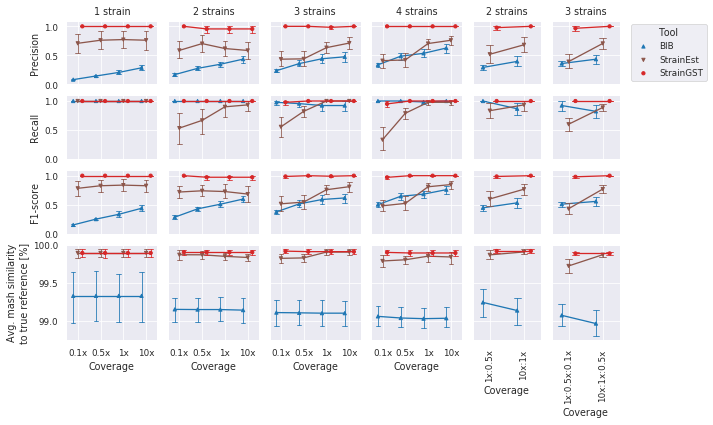

In [21]:
seaborn.set_context("paper")

# Apply jitter to prevent overlap of lines
# all_tools.loc[('straingst', all_tools['recall'] == 1.0), 'recall'] += 0.05
# all_tools.loc[('bib', all_tools['recall'] == 1.0), 'recall'] -= 0.05
# 
# all_tools.loc[('straingst', all_tools['avg_sim_pct'] == 100), 'recall'] += 0.05
# 
# all_tools.loc[('straingst', all_tools['sample_type2'] == 'single'), 'avg_sim_pct'] += 0.05


palette = seaborn.color_palette("tab10")
broad_palette = [palette[0], palette[5], palette[3]]
# [
#     "#00AFD7",
#     "#F36C3E",
#     "#808C00",
#     "#B12028",
#     "#FFCD00",
#     "#69488E"
# ]

sub_dfs = {
    "single": all_tools[all_tools['sample_type2'] == "single"].copy(),
    "equal2": all_tools[all_tools['sample_type2'] == "equal2"].copy(),
    "equal3": all_tools[all_tools['sample_type2'] == "equal3"].copy(),
    "equal4": all_tools[all_tools['sample_type2'] == "equal4"].copy(),
    "unequal2": all_tools[all_tools['sample_type2'] == "unequal2"].copy(),
    "unequal3": all_tools[all_tools['sample_type2'] == "unequal3"].copy(),
}

fig, axes = plt.subplots(4, 6, sharex='col', sharey='row', figsize=(10, 6), 
                         gridspec_kw={"width_ratios": [2, 2, 2, 2, 1.5, 1.5],
                                      "height_ratios": [1, 1, 1, 1.5]})

x_order = {
    "single": ["0.1x", "0.5x", "1x", "10x"],
    "equal2": ["0.1x", "0.5x", "1x", "10x"],
    "equal3": ["0.1x", "0.5x", "1x", "10x"],
    "equal4": ["0.1x", "0.5x", "1x", "10x"],
    "unequal2": ["1x_0.5x", "10x_1x"],
    "unequal3": ["1x_0.5x_0.1x", "10x_1x_0.5x"],
}

xticks = {
    "single": x_order['single'],
    "equal2": x_order['equal2'],
    "equal3": x_order['equal3'],
    "equal4": x_order['equal4'],
    "unequal2": [l.replace("_", ":") for l in x_order['unequal2']],
    "unequal3": [l.replace("_", ":") for l in x_order['unequal3']],
}


for col, (benchmark_type, data) in enumerate(sub_dfs.items()):
    order = x_order[benchmark_type]
    
    seaborn.pointplot(data=data.reset_index(), x="cov", y="precision", hue="tool", palette=broad_palette,
                      dodge=0.4, scale=0.6, errwidth=0.8, capsize=0.2,
                      order=order, hue_order=reversed(["straingst", "strainest", "bib"]), markers=["^", "v", "o"],
                      ax=axes[0, col])
    axes[0, col].legend().remove()
    axes[0, col].set_xlabel("")
    axes[0, col].set_ylabel("")

    seaborn.pointplot(data=data.reset_index(), x="cov", y="recall", hue="tool", palette=broad_palette,
                      dodge=0.4, scale=0.6, errwidth=0.8, capsize=0.2,
                      order=order, hue_order=reversed(["straingst", "strainest", "bib"]), markers=["^", "v", "o"],
                      ax=axes[1, col])
    axes[1, col].legend().remove()
    axes[1, col].set_xlabel("")
    axes[1, col].set_ylabel("")

    seaborn.pointplot(data=data.reset_index(), x="cov", y="f1", hue="tool", palette=broad_palette, 
                      dodge=0.4, scale=0.6, errwidth=0.8, capsize=0.2,
                      order=order, hue_order=reversed(["straingst", "strainest", "bib"]), markers=["^", "v", "o"],
                      ax=axes[2, col])
    axes[2, col].legend().remove()
    axes[2, col].set_xlabel("")
    axes[2, col].set_ylabel("")

    seaborn.pointplot(data=data.reset_index(), x="cov", y="avg_sim_pct", hue="tool", palette=broad_palette, 
                      dodge=0.4, scale=0.6, errwidth=0.8, capsize=0.2,
                      order=order, hue_order=reversed(["straingst", "strainest", "bib"]), markers=["^", "v", "o"],
                      ax=axes[3, col])
    axes[3, col].legend().remove()
    axes[3, col].set_xlabel("")
    axes[3, col].set_ylabel("")
    
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_ylim(0, 1.1)

axes[1, 0].set_ylabel("Recall")
axes[1, 0].set_ylim(0, 1.1)

axes[2, 0].set_ylabel("F1-score")
axes[2, 0].set_ylim(0, 1.1)

axes[3, 0].set_ylabel("Avg. mash similarity\nto true reference [%]")

titles = ["1 strain", 
          "2 strains",
          "3 strains",
          "4 strains",
          "2 strains",
          "3 strains"]

for col, benchmark_type in enumerate(sub_dfs.keys()):
    axes[0, col].set_title(titles[col])
    axes[-1, col].set_xlabel("Coverage")
    
    if benchmark_type.startswith("unequal"):
        axes[-1, col].set_xticklabels(xticks[benchmark_type], rotation=90, ha='center')
    
handles, labels = axes[0, -1].get_legend_handles_labels()
labels = [
    "BIB",
    "StrainEst",
    "StrainGST"
]
lgd = axes[0, -1].legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.5), title="Tool")

for ax in axes.flatten():
    ax.xaxis.grid(True)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.125, hspace=0.15)
fig.savefig('paper_fig/straingst_comparison.svg', bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.show()

In [49]:
all_tools.groupby(['tool', 'sample_type2']).mean()[['precision', 'recall', 'f1', 'avg_sim_pct']]

precision    recall        f1  avg_sim_pct
tool      sample_type2                                            
straingst equal2         0.966667  1.000000  0.980000    99.901042
          equal3         0.995833  0.994444  0.994286    99.910891
          equal4         1.000000  0.987500  0.992857    99.893549
          single         1.000000  1.000000  1.000000    99.892147
          unequal2       0.988889  1.000000  0.993333    99.917444
          unequal3       0.983333  1.000000  0.990476    99.885737
strainest equal2         0.621743  0.758333  0.714954    99.850852
          equal3         0.563707  0.844444  0.667627    99.866903
          equal4         0.590925  0.761494  0.685539    99.819574
          single         0.750556  1.000000  0.818333    99.892147
          unequal2       0.600714  0.883333  0.682976    99.886175
          unequal3       0.549260  0.744444  0.600567    99.794693
bib       equal2         0.307028  1.000000  0.455233    99.143560
          equal3         0.378003  0.944444  0.524092    99.100317
          equal4         0.496500  0.995833  0.647132    99.035845
          single         0.180007  1.000000  0.294466    99.326038
          unequal2       0.344392  0.933333  0.489767    99.185637
          unequal3       0.397063  0.872222  0.533466    99.014319

In [48]:
all_tools.isna().groupby(['tool', 'cov']).sum()

avg_mash_dist    f1   fn   fp  \
tool      sample_type2 cov                                           
straingst False        0.1x                    0.0   0.0  0.0  0.0   
                       0.5x                    0.0   0.0  0.0  0.0   
                       10x                     0.0   0.0  0.0  0.0   
                       10x_1x                  0.0   0.0  0.0  0.0   
                       10x_1x_0.5x             0.0   0.0  0.0  0.0   
                       1x                      0.0   0.0  0.0  0.0   
                       1x_0.5x                 0.0   0.0  0.0  0.0   
                       1x_0.5x_0.1x            0.0   0.0  0.0  0.0   
strainest False        0.1x                   19.0  19.0  0.0  0.0   
                       0.5x                    4.0   4.0  0.0  0.0   
                       10x                     0.0   0.0  0.0  0.0   
                       10x_1x                  0.0   0.0  0.0  0.0   
                       10x_1x_0.5x             0.0   0.0  0.0  0.0   
                       1x                      1.0   1.0  0.0  0.0   
                       1x_0.5x                 0.0   0.0  0.0  0.0   
                       1x_0.5x_0.1x            0.0   0.0  0.0  0.0   
bib       False        0.1x                    0.0   0.0  0.0  0.0   
                       0.5x                    0.0   0.0  0.0  0.0   
                       10x                     0.0   0.0  0.0  0.0   
                       10x_1x                  0.0   0.0  0.0  0.0   
                       10x_1x_0.5x             0.0   0.0  0.0  0.0   
                       1x                      0.0   0.0  0.0  0.0   
                       1x_0.5x                 0.0   0.0  0.0  0.0   
                       1x_0.5x_0.1x            0.0   0.0  0.0  0.0   

                                     num_strains  precision  recall  \
tool      sample_type2 cov                                            
straingst False        0.1x                  0.0        0.0     0.0   
                       0.5x                  0.0        0.0     0.0   
                       10x                   0.0        0.0     0.0   
                       10x_1x                0.0        0.0     0.0   
                       10x_1x_0.5x           0.0        0.0     0.0   
                       1x                    0.0        0.0     0.0   
                       1x_0.5x               0.0        0.0     0.0   
                       1x_0.5x_0.1x          0.0        0.0     0.0   
strainest False        0.1x                  0.0       19.0     0.0   
                       0.5x                  0.0        4.0     0.0   
                       10x                   0.0        0.0     0.0   
                       10x_1x                0.0        0.0     0.0   
                       10x_1x_0.5x           0.0        0.0     0.0   
                       1x                    0.0        1.0     0.0   
                       1x_0.5x               0.0        0.0     0.0   
                       1x_0.5x_0.1x          0.0        0.0     0.0   
bib       False        0.1x                 60.0        0.0     0.0   
                       0.5x                 60.0        0.0     0.0   
                       10x                  60.0        0.0     0.0   
                       10x_1x               15.0        0.0     0.0   
                       10x_1x_0.5x          15.0        0.0     0.0   
                       1x                   60.0        0.0     0.0   
                       1x_0.5x              15.0        0.0     0.0   
                       1x_0.5x_0.1x         15.0        0.0     0.0   

                                     sample_type   tp  avg_sim_pct  
tool      sample_type2 cov                                          
straingst False        0.1x                  0.0  0.0          0.0  
                       0.5x                  0.0  0.0          0.0  
                       10x                   0.0  0.0          0.0  
                       1

## Mock community analysis

In [22]:
true_mock_strains = ["Esch_coli_SEC470", "Esch_coli_UTI89", "Esch_coli_Sakai_substr_RIMD_0509952", "Esch_coli_E24377A"]
ix = [ref + ".sketch" for ref in true_mock_strains]

display(dmatrix_only_in_db.loc[ix, :].idxmin(axis=1))
display((1-dmatrix_only_in_db.loc[ix, :].min(axis=1))*100)

Esch_coli_SEC470.sketch                        Esch_coli_SEC470.sketch
Esch_coli_UTI89.sketch                          Esch_coli_UM146.sketch
Esch_coli_Sakai_substr_RIMD_0509952.sketch        Esch_coli_149.sketch
Esch_coli_E24377A.sketch                      Esch_coli_E24377A.sketch
dtype: object

Esch_coli_SEC470.sketch                       100.000000
Esch_coli_UTI89.sketch                         99.945064
Esch_coli_Sakai_substr_RIMD_0509952.sketch     99.891750
Esch_coli_E24377A.sketch                      100.000000
dtype: float64

In [23]:
display(dmatrix_bib.loc[ix, :].idxmin(axis=1))
display((1-dmatrix_bib.loc[ix, :].min(axis=1))*100)

Esch_coli_SEC470.sketch                       Esch_coli_K-12_substr_GM4792.sketch
Esch_coli_UTI89.sketch                                      Esch_coli_H105.sketch
Esch_coli_Sakai_substr_RIMD_0509952.sketch                   Esch_coli_108.sketch
Esch_coli_E24377A.sketch                                     Esch_coli_S40.sketch
dtype: object

Esch_coli_SEC470.sketch                       99.247026
Esch_coli_UTI89.sketch                        98.487400
Esch_coli_Sakai_substr_RIMD_0509952.sketch    99.975888
Esch_coli_E24377A.sketch                      99.008296
dtype: float64

In [24]:
straingst_data = []
with (STRAINGST_DIR / "mock_community/sample.tsv").open() as f:
    straingst_data.extend(parse_straingst(f))
    
mock_straingst = pandas.DataFrame(straingst_data).set_index('i')
mock_straingst

,strain,gkmers,ikmers,skmers,cov,kcov,gcov,acct,even,spec,rapct,wscore,score
i,,,,,,,,,,,,,
0,Esch_coli_SEC470,49547,49456,87631,0.980,6.197,5.931,0.732,0.983,0.740,0.552,0.513,0.694
1,Esch_coli_UM146,49228,25021,39148,0.868,3.092,2.665,0.611,0.933,0.969,0.240,0.447,0.462
2,Esch_coli_149,51737,17598,17428,0.547,1.976,1.016,0.445,0.857,0.977,0.099,0.175,0.179
3,Esch_coli_E24377A,48548,9543,7808,0.353,1.755,0.602,0.249,0.781,0.921,0.054,0.049,0.054


In [25]:
mock_strainest = pandas.read_csv(STRAINEST_DIR / "mock_community/abund.txt", sep='\t').set_index('OTU')
mock_strainest = mock_strainest[mock_strainest['alignments.bam'] > 0.01].sort_values('alignments.bam', ascending=False)
mock_strainest

,alignments.bam
OTU,
Esch_coli_SEC470.fa,0.478065
Esch_coli_UM146.fa,0.271965
Esch_coli_149.fa,0.110427
Esch_coli_E24377A.fa,0.053637
Esch_coli_APEC_IMT5155.fa,0.028480
Esch_coli_RM14721.fa,0.010885


In [26]:
mock_bib = pandas.read_csv(BIB_DIR / "mock_community/abundance.txt.m_alphas", delim_whitespace=True, comment='#', names=['m_theta', 'alpha', 'beta'])
mock_bib = mock_bib.apply(pandas.to_numeric, errors='ignore').set_index(pandas.Index(['noise'] + bib_db))
mock_bib = mock_bib[mock_bib['m_theta'] > 0.01].sort_values('m_theta', ascending=False)

mock_bib

,m_theta,alpha,beta
noise,0.477559,55021.017810,60191.98219
Esch_coli_K-12_substr_GM4792,0.152710,17594.152740,97618.84726
Esch_coli_H105,0.085425,9842.082476,105370.91750
Esch_coli_108,0.075677,8718.957051,106494.04290
Esch_coli_S40,0.045082,5194.065815,110018.93420
Shig_flexneri_G1663,0.044382,5113.364567,110099.63540
Esch_coli_LHM10-1,0.023741,2735.292005,112477.70800
Esch_coli_MSHS_133,0.022792,2625.958260,112587.04170
Shig_dysenteriae_80-547,0.016554,1907.245103,113305.75490
Esch_coli_IMT16316,0.013103,1509.625338,113703.37470
